In [1]:
import glob, pickle
import pandas as pd
import numpy as np
import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import statsmodels.api as sm

%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib as mpl
import matplotlib.pyplot as plt
#Enlargen
sns.set_context('poster')

plt.style.use('ggplot')

In [2]:
# The date of the prices is only found in the .csv filename
def extract_date(filename):
    return datetime.date(int(filename[20:24]), int(filename[18:20]), int(filename[16:18]))

def merge_csvs(filenames):
    files = []
    for filename in filenames:
        df = pd.read_csv(filename)
        df['Date'] = extract_date(filename)
        files.append(df)
    return pd.concat(files)

def output_figure(filename):
    """
    Save the most recently generated chart as a png with the filename passed as an argument
    """
    plt.tight_layout()
    plt.savefig('./charts/' + filename + '.png', dpi=200)
    
def percentify_y():
    plt.gca().yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0f%%'))
    
def dollarify_y():
    plt.gca().yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('$%d'))

In [3]:
csvfiles = glob.glob('./raw/*.csv')
df = merge_csvs(csvfiles)

In [4]:
# Cleaning

# Remove odd string in low quality weed prices

df['LowQ'].replace('I feel bad for these guys -->', np.nan, inplace=True)

# Remove occasional $s to convert all prices to float

for col in ['HighQ','MedQ','LowQ']:
    df.ix[:,col] = [float(str(x).replace('$','')) for x in df[col].values]

In [5]:
# Create data for overall median prices from 2013-2015 map

avgstateprices = df.groupby('State').aggregate(np.median)

'''
After looking at the data, a few states with a small number of observations for low quality weed prices have
unreasonably high prices; I'm rounding them down to the highest "reasonable" value here to keep the map scale well-
bounded
'''

outlier_states = ['Montana','New Hampshire','Alaska', 'North Dakota']
avgstateprices.loc[outlier_states,'LowQ'] = avgstateprices.loc['Maine','LowQ']

avgstateprices.to_csv('./outputs/Average_prices.csv')

In [6]:
# Reformat data for animated map with monthly median prices

df['Month'] = [x.month for x in df['Date']]
df['Year'] = [x.year for x in df['Date']]

high_ts = pd.DataFrame(df.groupby(['State','Month','Year']).aggregate(np.median)['HighQ'])
high_ts.reset_index(inplace=True)

In [7]:
# Restructure dataset so rows are states and columns are unique month + year combinations

high_ts['MonthYear'] = ['{:02d}'.format(x) + str(y) for x, y in zip(high_ts['Month'].values, high_ts['Year'].values)]

del high_ts['Month']
del high_ts['Year']

high_ts = high_ts.pivot(columns='MonthYear', index='State')

In [8]:
# Remove unnecessary MultiIndex

high_ts.columns.names=[None, None]
high_ts.columns = high_ts.columns.droplevel()
high_ts.reset_index(inplace=True)

In [9]:
high_ts.to_csv('./outputs/High_quality_prices_over_time.csv', index=False)

In [10]:
# State Cluster Analysis

# Restructure DF
cluster_df = high_ts.set_index('State').transpose()
cluster_df.index = pd.to_datetime(cluster_df.index, format='%m%Y')
cluster_df.sort_index(inplace=True)

In [11]:
smoothed_cluster_df = pd.ewma(cluster_df,span=30)

percent_chg_df = smoothed_cluster_df.pct_change()

# Remove first row since it's NaN for % change
percent_chg_df.drop(percent_chg_df.index[0:2], inplace=True)

In [12]:
# Rolled my own "best" clustering algorithm
# Commenting out and calling pickle for now because I forgot to set a random seed to make this reproducible

# best_score = {'silhouette': 0, 'n_clusters': 0, 'assignment': None}

# X = percent_chg_df.transpose().values
    
# for param in (np.arange(10)+3):
#     for i in range(50):
#         clf = KMeans(n_clusters=param)
#         clf.fit(X)
#         clusters = pd.Series(clf.predict(X), index=percent_chg_df.columns)
#         if silhouette_score(X,clusters.values) > best_score['silhouette']:
#             best_score['silhouette'] = silhouette_score(X,clusters.values)
#             best_score['n_clusters'] = param
#             best_score['assignment'] = clusters

In [13]:
# with open('cluster.pkl', 'wb') as file:
#     pickle.dump(best_score,file)

In [14]:
with open('cluster.pkl', 'rb') as file:
    best_score = pickle.load(file)

clusters = best_score['assignment']
cluster_states = dict()
for i in (1 + np.arange(best_score['n_clusters'])):
    cluster_states[i] = list(clusters[clusters == i-1].index)

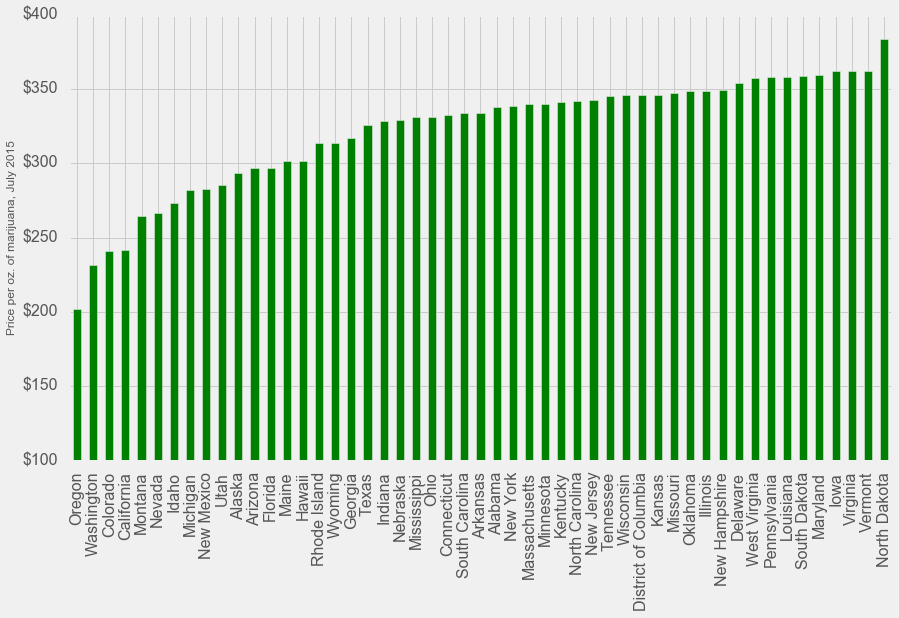

In [15]:
#States ranked by prices at end
with plt.style.context('fivethirtyeight'):
    cluster_df.ix['2015-07-01',:].sort_values().plot(kind='bar', color='green', ylim=(100,400))
    dollarify_y()
    plt.xlabel('')
    plt.ylabel('Price per oz. of marijuana, July 2015')
    output_figure('states_final_prices_ranked')

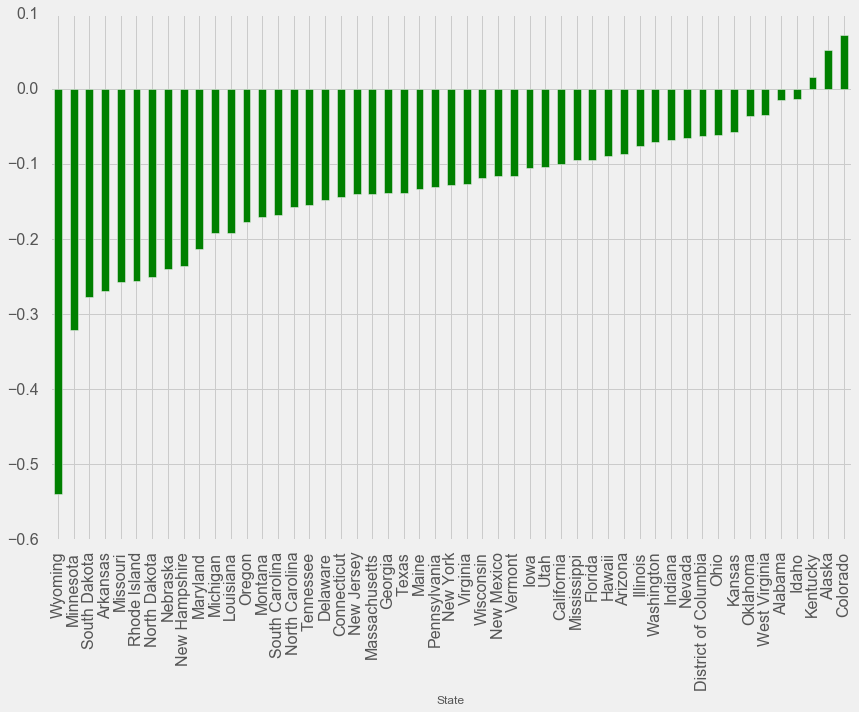

In [16]:
# States ranked by average monthly price change -- Unused in post

with plt.style.context('fivethirtyeight'):
    (percent_chg_df.median()*100).sort_values().plot(kind='bar', color='green')
#     output_figure('states_monthly_price_change_ranked')

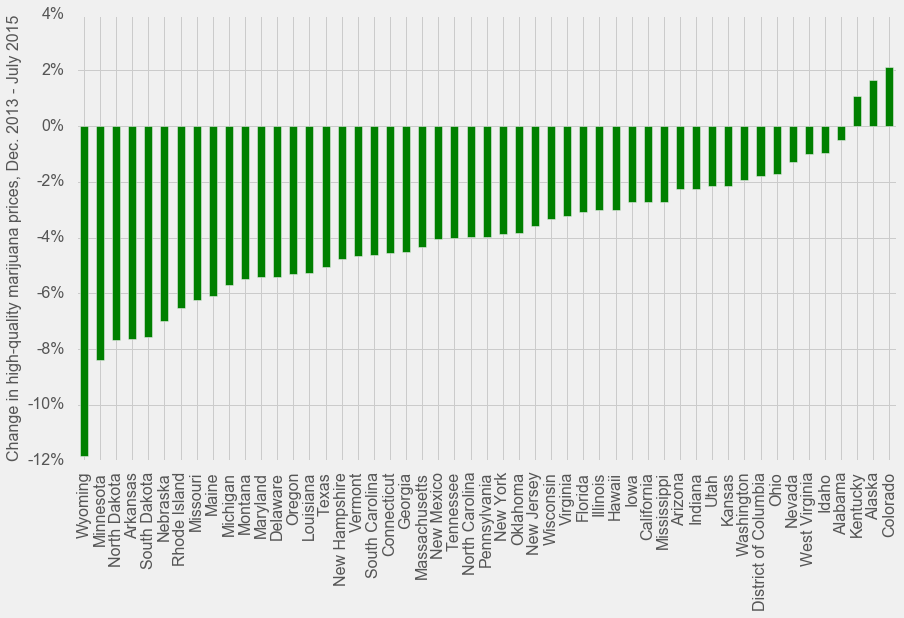

In [17]:
#Overall Percent Change

with plt.style.context('fivethirtyeight'):
    overall_pct_change = 100*(cluster_df.ix['2015-07-01',:] - cluster_df.ix['2013-12-01',:])/cluster_df.ix['2013-12-01',:]
    overall_pct_change.sort_values().plot(kind='bar', color='green')
    percentify_y()
    plt.xlabel('')
    plt.ylabel('Change in high-quality marijuana prices, Dec. 2013 - July 2015', fontsize=16)
    output_figure('states_beginning_to_end_perc_change')

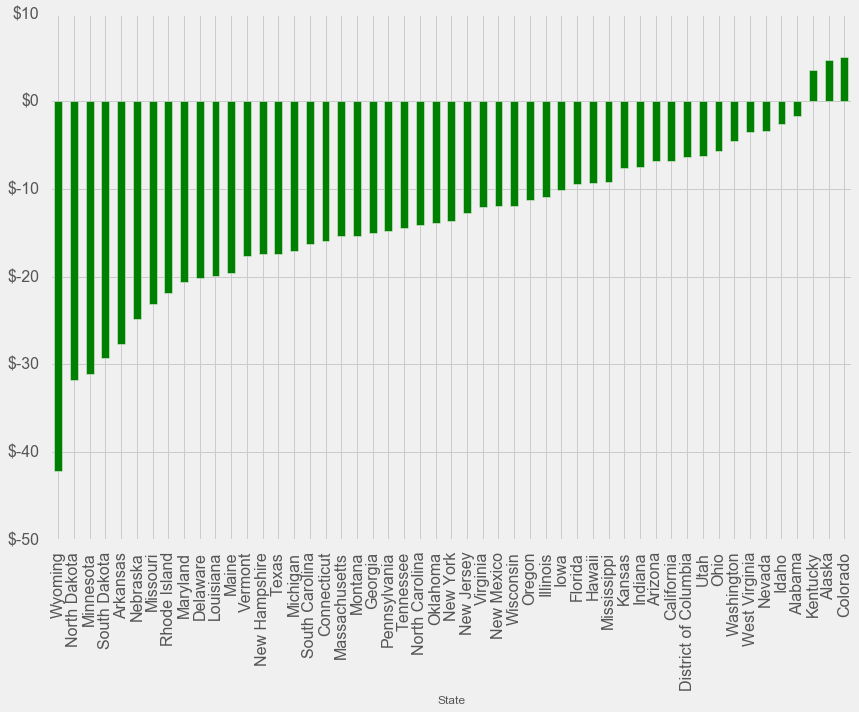

In [18]:
#Dollar change
with plt.style.context('fivethirtyeight'):
    dollar_change = (cluster_df.ix['2015-07-01',:] - cluster_df.ix['2013-12-01',:])
    dollar_change.sort_values().plot(kind='bar', color='green')
    dollarify_y()

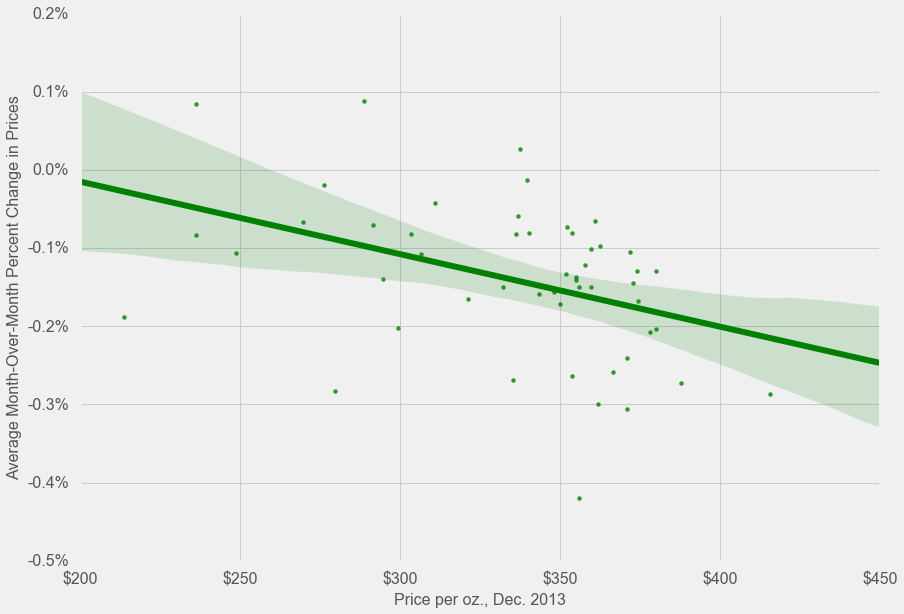

In [19]:
# Hey, a clear negative relationship = price convergence
with plt.style.context('fivethirtyeight'):
    scatter_df = pd.concat([pd.Series(100*percent_chg_df.mean(),name='Average Monthly Percent Change in Prices'),pd.Series(cluster_df.ix['2013-12-01',:],name='Price per oz., Dec. 2013')],axis=1)
    sns.regplot(y=scatter_df.columns[0],x=scatter_df.columns[1],data=scatter_df, color='green')
    plt.gca().yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f%%'))
    plt.gca().xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('$%d'))
    plt.ylabel('Average Month-Over-Month Percent Change in Prices', fontsize=16)
    plt.xlabel('Price per oz., Dec. 2013', fontsize=16)
    output_figure('states_initial_prices_versus_average_change')

In [20]:
# Find states with largest below-trend decreases in price

import statsmodels.api as sm
y = scatter_df[scatter_df.columns[0]].values
X = sm.add_constant(scatter_df[scatter_df.columns[1]].values)
model = sm.OLS(y, X)

reg = model.fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     9.763
Date:                Wed, 10 Feb 2016   Prob (F-statistic):            0.00299
Time:                        09:41:10   Log-Likelihood:                 50.833
No. Observations:                  51   AIC:                            -97.67
Df Residuals:                      49   BIC:                            -93.80
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.1709      0.101      1.700      0.095        -0.031     0.373
x1            -0.0009      0.000     -3.125      0.003        -0.002    -0.000
==============================================================================
Omnibus:                        3.703   Durbin-Watson:                   1.507
Prob(Omnibus):                  0.157   Jarque-Bera (JB):                2.724
Skew:                          -0.532   Prob(JB):                        0.256
Kurtosis:                       3.389   Cond. No.                     2.67e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

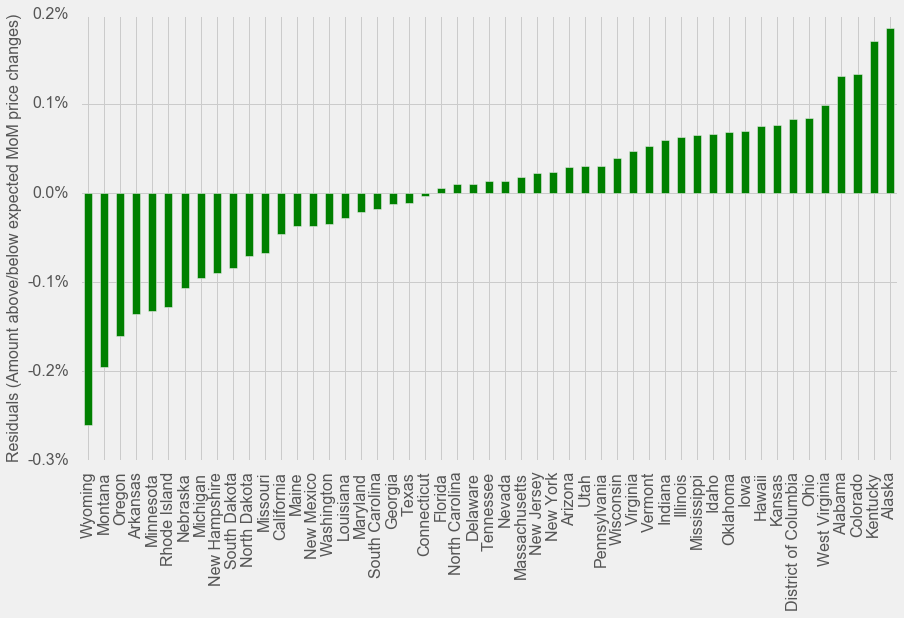

In [21]:
with plt.style.context('fivethirtyeight'):
    pd.Series(reg.resid, index=scatter_df.index).sort_values().plot.bar(color='green')
    plt.gca().yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f%%'))
    plt.ylabel('Residuals (Amount above/below expected MoM price changes)', fontsize=16)
    plt.xlabel('')
    output_figure('state_percent_change_residuals')

In [22]:
# Swap for a better numbering exposition-wise

(cluster_states[4],cluster_states[2],cluster_states[1],cluster_states[3]) = (cluster_states[1],cluster_states[2],cluster_states[3],cluster_states[4])

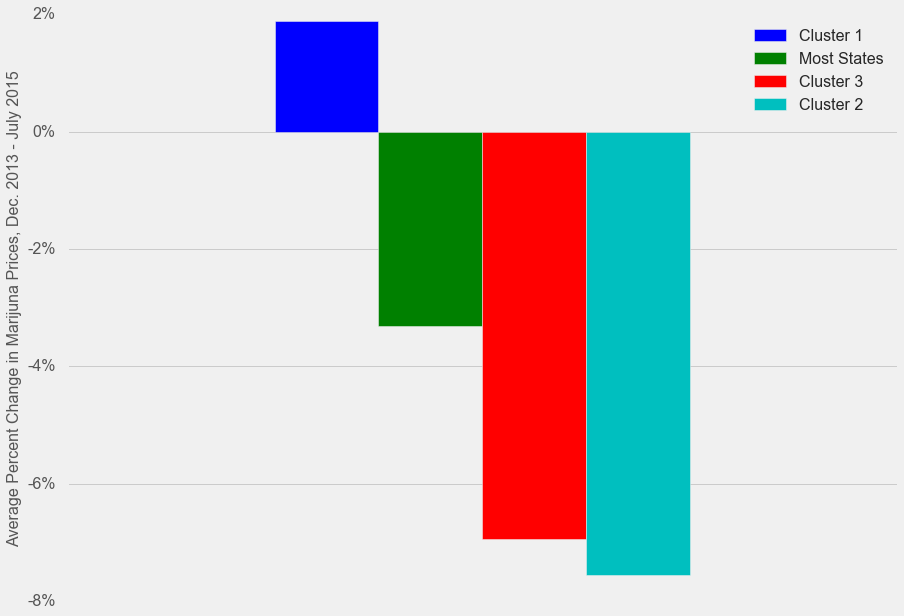

In [23]:
# Overall % change by clusters

series = []
for key in cluster_states.keys():
    series.append(pd.Series(overall_pct_change[cluster_states[key]].transpose().mean(),name='Cluster {}'.format(key)))
overall_pct_clusters = pd.concat(series, axis=1)
#Use non-generic name for Cluster 4
overall_pct_clusters.columns = ['Most States' if x == 'Cluster 4' else x for x in overall_pct_clusters.columns]

with plt.style.context('fivethirtyeight'):
#   Odd munging to sort bars
    overall_pct_clusters = overall_pct_clusters.transpose().sort_values(by=0, ascending=False)
    overall_pct_clusters.transpose().plot.bar()
    percentify_y()
    plt.ylabel('Average Percent Change in Marijuna Prices, Dec. 2013 - July 2015', fontsize=16)
    plt.gca().get_xaxis().set_visible(False)
    output_figure('clusters_overall_perc_change')

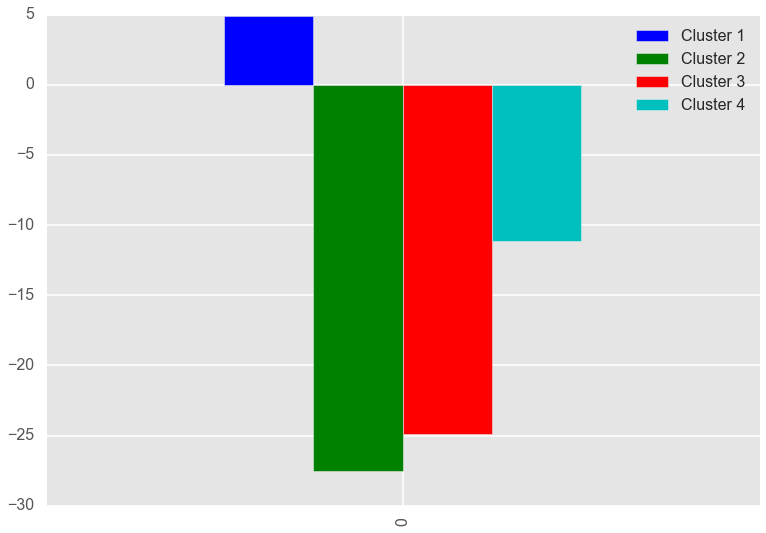

In [24]:
# Overall $ change by clusters -- Unused in post

series = []
for key in cluster_states.keys():
    series.append(pd.Series(dollar_change[cluster_states[key]].transpose().mean(),name='Cluster {}'.format(key)))
dollar_change_clusters = pd.concat(series, axis=1)

dollar_change_clusters.plot(kind='bar')

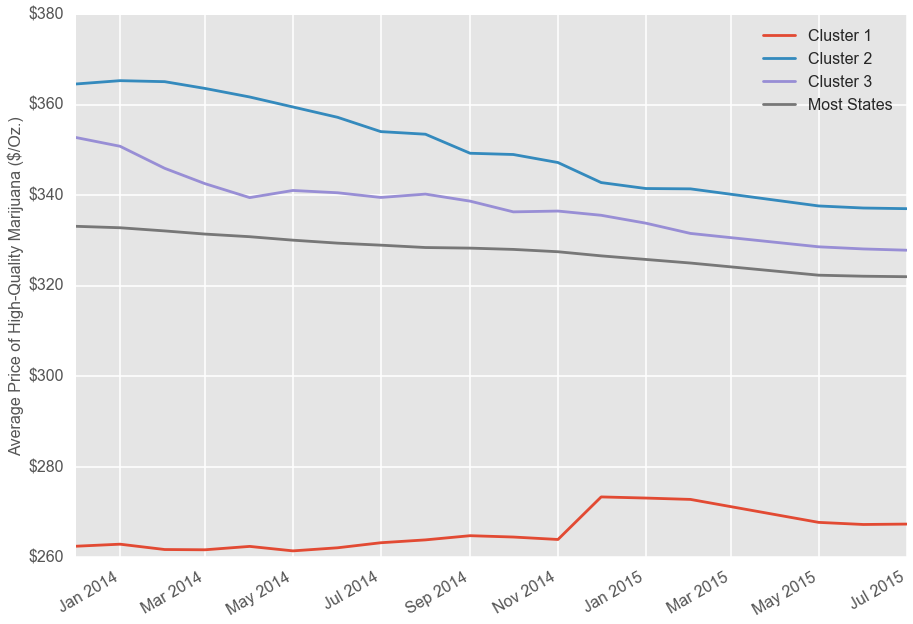

In [25]:
# Average time trends by cluster
series = []
for key in cluster_states.keys():
    series.append(pd.Series(cluster_df[cluster_states[key]].transpose().mean(),name='Cluster {}'.format(key)))
cluster_ts = pd.concat(series, axis=1)
#Use non-generic name for Cluster 4
cluster_ts.columns = ['Most States' if x == 'Cluster 4' else x for x in cluster_ts.columns]


with plt.style.context('ggplot'):
    cluster_ts.plot()
    dollarify_y()
    plt.ylabel('Average Price of High-Quality Marijuana ($/Oz.)', fontsize=16)
    output_figure('clusters_time_series_prices')

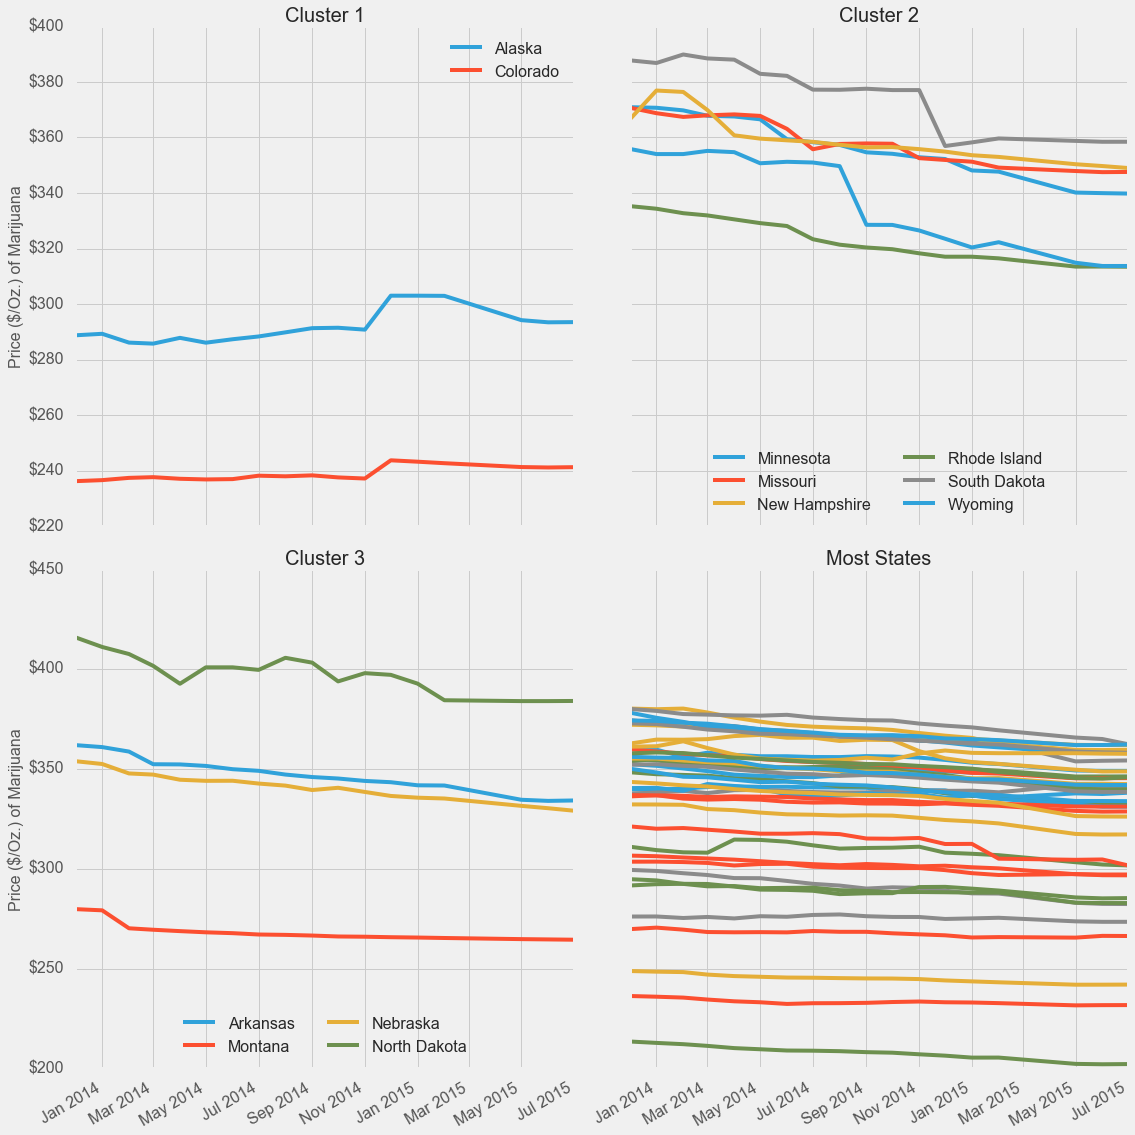

In [26]:
with plt.style.context('fivethirtyeight'):

    fig, ax = plt.subplots(2,2, sharex='col', sharey='row', figsize=(16,16))
    cluster_df.columns.name = '' #Nuke 'State' Name to Clean Up Legend
    cluster_df[cluster_states[1]].plot(ax=ax[0,0])
    ax[0,0].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('$%d'))
    cluster_df[cluster_states[2]].plot(ax=ax[0,1])
    dollarify_y()
    cluster_df[cluster_states[3]].plot(ax=ax[1,0])
    cluster_df[cluster_states[4]].plot(legend=False, ax=ax[1,1])
    dollarify_y()

    ax[0,0].set_title('Cluster 1', fontsize=20)
    ax[0,0].set_ylabel('Price ($/Oz.) of Marijuana', fontsize=16)
    ax[0,1].set_title('Cluster 2', fontsize=20)
    ax[1,0].set_title('Cluster 3', fontsize=20)
    ax[1,0].legend(loc='lower center', ncol=2)
    ax[0,1].legend(ncol=2, loc='lower center')
    ax[1,0].set_ylabel('Price ($/Oz.) of Marijuana', fontsize=16)
    ax[1,1].set_title('Most States', fontsize=20)

    output_figure('within_cluster_time_trends')

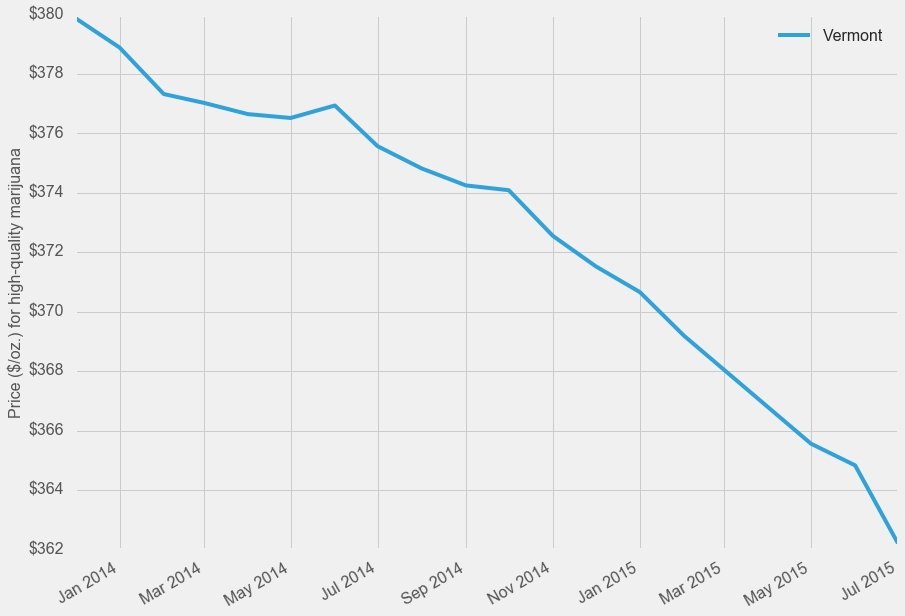

In [27]:
with plt.style.context('fivethirtyeight'):
    cluster_df['Vermont'].plot()
    plt.legend()
    dollarify_y()
    plt.ylabel('Price ($/oz.) for high-quality marijuana', fontsize=16)
    output_figure('vermont_time_series')